![CC-BY-SA](https://mirrors.creativecommons.org/presskit/buttons/88x31/svg/by-sa.svg)


This notebook was created by [Bernardo Freitas Paulo da Costa](http://www.im.ufrj.br/bernardofpc),
and is licensed under Creative Commons BY-SA.

Antes de enviar este Teste, verifique que tudo está funcionando como esperado.
Por exemplo, **rode o código inteiro, do zero**.
Para isso, vá no menu, escolha _Kernel_, depois _Restart & Run All_.

Verifique, também, que você respondeu todas as questões:
* as questões de código têm `YOUR CODE HERE` (e você pode apagar o `raise NotImplemented` ao incluir sua resposta)
* as questões discursivas têm "YOUR ANSWER HERE".

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Convergência de vetores na iterção QR

Vamos ver como os vetores das matrizes $Q$ do algoritmo QR iterativo convergem para os autovetores de $A = QDQ^T$.

## Gerando matrizes diagonalizáveis aleatórias

Para inclusive poder verificar sem problemas a qualidade da diagonalização,
vamos gerar matrizes ortogonais aleatórias $Q$ e matrizes diagonais aleatórias $D$.

Uma forma muito simples de gerar matrizes ortogonais aleatórias é fazer a fatoração QR de uma matriz $A$ qualquer
(veja a função `np.linalg.qr`).

### Questão 1. Parte ortogonal

Escreva uma função que, dado $n$, retorne uma matriz aleatória $n \times n$ ortogonal.

In [2]:
def randq(n):
    M = np.random.rand(n, n)
    u, s, vh = np.linalg.svd(M, full_matrices=False)
    return u @ vh

Verificando que ela é ortogonal:

In [3]:
i = np.identity(20)
for _ in range(10):
    Q = randq(20)
    assert np.allclose(Q.T @ Q, i)

Verificando que é aleatória

In [4]:
np.random.seed(1)
for _ in range(10):
    n = np.random.randint(30,100)
    prev = randq(n)
    for _ in range(3):
        nova = randq(n)
        assert np.linalg.norm(prev - nova)**2 >= n/2

### Questão 2. Matriz diagonalizável

Agora, escreva uma função que, dado $n$, retorna uma matriz diagonalizável aleatória $n \times n$,
cujos autovalores sejam reais aleatórios entre $-n$ e $n$.
Retorne também os autovalores num vetor `a_val`
e os autovetores correspondentes numa lista (de arrays `numpy`) `a_vet`.

In [5]:
def rand_diag(n):
    a_val = np.array([np.random.random()*np.random.choice([-1,1])*n for i in range(n)])
    val_diag = np.diag(a_val)
    M=randq(n)
    a_vet=M.transpose()
    M_ = M @ val_diag @ M.transpose()
    return (M_, a_val, a_vet)

Verificando que realmente vale $Av = \lambda v$:

In [6]:
for _ in range(20):
    A,ls,vs = rand_diag(30)
    for l,v in zip(ls,vs):
        assert np.allclose(A@v, l*v)

In [7]:
np.random.seed(2)
for _ in range(20):
    A,ls,vs = rand_diag(35)
    # Há (bastantes) autovalores positivos e negativos
    assert sum(ls < 0) > 5
    assert sum(ls > 0) > 5

### Questão 3. Autovetores ordenados

Modifique rand_diag para que os autovalores venham em ordem decrescente do módulo.
A função `argsort` pode ser útil: não queremos mudar o sinal dos autovalores, mas precisamos ordenar `abs(a_val)`.

In [8]:
def rand_diag(n):
    a_val = np.array([np.random.random()*n for i in range(n)])
    sort=np.argsort(a_val)
    a_val = [a_val[i] for i in sort]
    a_val.reverse()
    a_val = np.array([i * np.random.choice([-1, 1]) for i in a_val])
    val_diag = np.diag(a_val)
    M=randq(n)
    a_vet=M.transpose()
    M_ = M @ val_diag @ M.transpose()
    return (M_, a_val, a_vet)

In [9]:
np.random.seed(2)
for _ in range(20):
    A,ls,vs = rand_diag(30)
    for l1,l2 in zip(ls[:-1], ls[1:]):
        assert abs(l1) > abs(l2)
    for l,v in zip(ls,vs):
        assert np.allclose(A@v, l*v)
    # Há (bastantes) autovalores positivos e negativos
    assert sum(ls < 0) > 5
    assert sum(ls > 0) > 5

## CVGA Projetivo

Vamos usar o ângulo entre vetores para obter uma velocidade de convergência.
Lembre que $\cos \theta = \frac{u\cdot v}{|u| \cdot |v|}$.

Se temos uma base ortogonal $e_i$, e uma base $u_i = \pm e_i$,
elas estão "alinhadas", por mais que os vetores possam estar com o sentido trocado.
Por isso, não vamos usar o ângulo ("orientado") dado pela fórmula acima,
mas o **menor** ângulo $\hat\theta$ entre as retas determinadas por $u$ e $v$.
Este é bastante parecido:
$$ \cos \hat\theta = \frac{|u\cdot v|}{|u| \cdot |v|}. $$

Este ângulo é importante em geometria projetiva, porque apenas a direção das retas importa, não a sua orientação.

### Questão 4. Função ângulo

Usando a fórmula anterior, escreva uma função que calcula o ângulo entre as retas de direção $u$ e $v$.

In [10]:
def proj_angle(u,v):
    u = np.array(u)
    v = np.array(v)
    cos = np.abs(np.sum(u*v))/(np.power(np.sum(u*u),1/2)*np.power(np.sum(v*v),1/2))
    return np.arccos(cos)

In [11]:
assert(proj_angle([1,0], [0,1]) == np.pi/2)
assert(proj_angle([1,0], [1,0]) == 0)

## Algoritmo QR: iteração de bases

O algoritmo QR iterado, dada uma matriz $A$,
repetidamente usa a fatoração QR para diagonalizá-la.
Começando com uma matriz $Q_0$ qualquer (em geral, a identidade), em cada etapa, o algoritmo

1. Fatora a matriz $A Q_{n-1}$ como $Q_n R_n$
2. Se $R_n$ for "quase diagonal" (use a função `np.allclose`), retorna
3. Senão, itera

Estas operações correspondem a aplicar a ideia da iteração direta não apenas em um vetor, mas em uma _base_.

### Questão 5. QR com bases

Escreva a função `itera_qr` que retorna as matrizes $Q_n$ e $R_n$ em listas.
A matriz $Q_n$ pode ser vista como tendo em suas colunas uma "base" de vetores
que está "convergindo" para a base de autovetores de $A$.

In [12]:
def itera_qr(A, maxiter=10000):
    A_ = np.array(A)
    Qs = []
    Rs = []
    for i in range(maxiter):
        (Q, R) = np.linalg.qr(A_,)
        Qs.append(Q)
        Rs.append(R)
        A_ = A @ Q
        dR = np.diag(R)
        if np.allclose(R, np.diag(dR)):
            return Qs, Rs
    return Qs, Rs

#### 5.1 Qn ortogonais

Este é fácil.

In [13]:
np.random.seed(3)
for n in np.random.randint(4,8, size=10):
    A, _, _ = rand_diag(n)
    i = np.identity(n)
    Qs,_ = itera_qr(A)
    for Qn in Qs:
        assert np.allclose(i, Qn @ Qn.T)

#### 5.2 $R_n$ quase diagonal.

No fim do algoritmo, teremos em $R_n$ a candidata para a matriz dos autovalores de $A$.

(Observação: dependendo da versão do numpy que você usar, pode ser que a diagonal de $R$ tenha apenas valores positivos.  Neste caso, insira um comentário abaixo, e troque o segundo `assert` para `abs(a_vals)`, para verificar no seu computador se o seu algoritmo está funcionando.)

In [14]:
np.random.seed(32)
for n in np.random.randint(4,8, size=10):
    A, a_vals, _ = rand_diag(n)
    _,Rs = itera_qr(A, maxiter=5000)
    d_Rs = Rs[-1].diagonal()
    assert np.allclose(Rs[-1], np.diag(d_Rs))
    assert np.allclose(d_Rs, a_vals)

### 6. Distância entre bases

Escreva uma função que, dadas duas matrizes $B_1$ e $B_2$ (representando bases do $R^n$),
calcula as distâncias entre os vetores **linhas** correspondentes, e as retona num array ou lista.
(usaremos vetores linhas, e não colunas, porque são estes que vêm na lista `a_vec`;
atenção, a matriz $Q$ tem a base nas colunas...)

In [15]:
def base_distances(B1,B2):
    return [np.power(np.sum((B1[i]-B2[i])*(B1[i]-B2[i])),1/2) for i in range(len(B1))]

In [16]:
I3 = np.identity(3)
assert all(base_distances(I3, I3) == np.array([0,0,0]))
assert all(base_distances(I3, -I3) == np.array([2,2,2]))

In [17]:
I3 = np.identity(3)
assert all(base_distances(I3, [[0,1,0], [0,0,1],[1,0,0]]) == np.sqrt(np.array([2,2,2])))
assert all(base_distances(I3, [[1,0,0], [0,1,0], [1,0,1]]) == np.array([0,0,1]))

### 7. Autovetores

Com ajuda função anterior, faça um gráfico da evolução da distância (euclidiana)
entre os autovetores de uma matriz $3\times 3$ (aleatória, diagonalizável)
e os vetores correspondentes vindos da iteração QR.

Text(0.5, 1.0, 'Diferença entre autovetores e fatoração QR')

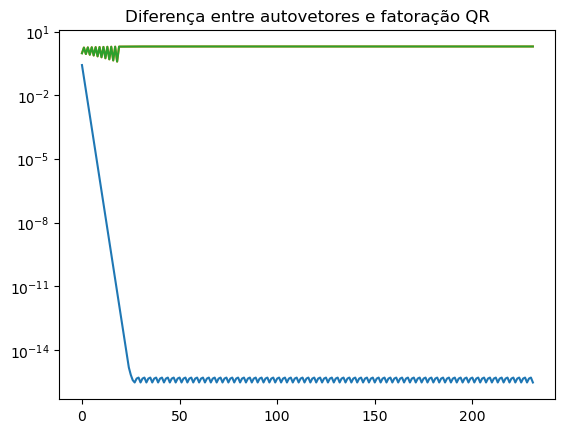

In [18]:
np.random.seed(5)
A, _, a_vec = rand_diag(3)
Qs,_ = itera_qr(A)
d = []
for Q in Qs:
    QT = np.array(Q).T
    distances = (base_distances(a_vec, QT))
    d.append(distances)
plt.semilogy(d)
plt.title('Diferença entre autovetores e fatoração QR')

### 8. Ângulos

Agora, em vez de calcular a distância entre os vetores,
faça o gráfico do ângulo entre as retas respectivas,
como já fizemos no início.

Aproveite a ideia da função que calcula a distância entre bases para fazer uma `base_angles` análoga.

In [19]:
def base_angles(B1,B2):
    return [proj_angle(B1[i], B2[i]) for i in range(len(B1))]

C:\Users\brand\AppData\Local\Temp\ipykernel_540\2663779033.py:5: RuntimeWarning: invalid value encountered in arccos
  return np.arccos(cos)


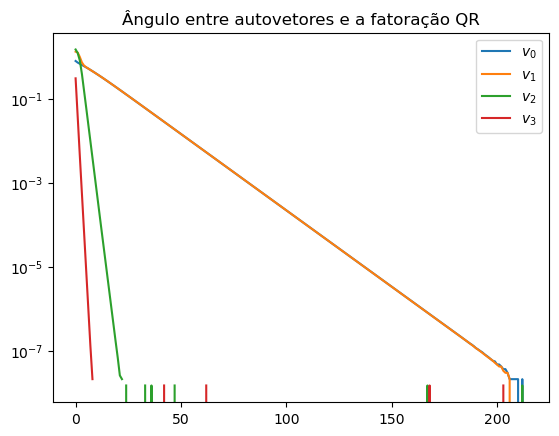

In [20]:
np.random.seed(6)
A, _, a_vec = rand_diag(4)
Qs,Rs = itera_qr(A)
tetha = []
for Q in Qs:
    QT = np.array(Q).T
    tetha_ = base_angles(a_vec, QT)
    tetha.append(tetha_)
plt.semilogy(tetha)
plt.title('Ângulo entre autovetores e a fatoração QR')
plt.legend(['$v_{}$'.format(i) for i in range(4)], loc=0);

### 9. Velocidade de convergência

Use os ângulos calculados para estimar a taxa de convergência de cada vetor para o autovetor correspondente.
Como isso se relaciona com os autovalores calculados?

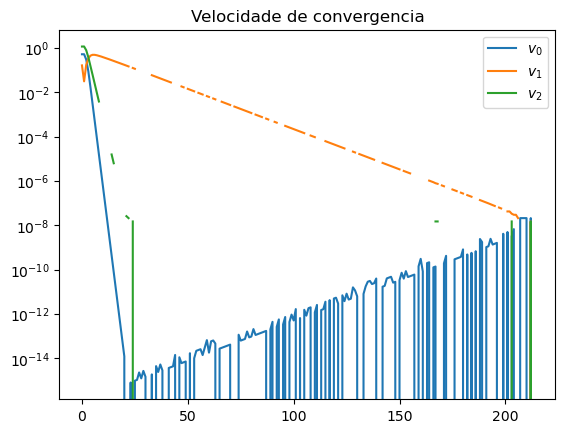

In [21]:
v = []
for i in range(len(tetha)):
    a = np.insert(tetha[i], len(tetha[i]), 0)
    dif = np.insert(tetha[i], 0, 0)
    speed = (np.abs(a - dif))[1:-1]
    v.append(speed)
plt.semilogy(v)
plt.title('Velocidade de convergencia')
plt.legend(['$v_{}$'.format(i) for i in range(4)], loc=0)

YOUR ANSWER HERE

### 10. Precisão para o ângulo projetivo

Se você fez corretamente o gráfico anterior,
algumas linhas pararam de aparecer por volta de $10^{-8} = \sqrt{\epsilon}$.
Isso se deve à imprecisão do computador ao calcular $\arccos(1 - x)$ com $x$ muito pequeno.
Para contornar isso, vamos usar uma fórmula estável para o ângulo.

Se temos dois vetores $u$ e $v$, podemos projetar (como fizemos) $v$ em $u$ e obter o cosseno do ângulo entre eles.
Para contornar o problema de precisão quando $u$ e $v$ estão quase alinhados,
vamos dar mais informação ao nosso programa: vamos calcular o **seno** do ângulo também.
Para isso, "Gram-Schmidt": basta retirar de $v$ a componente na direção de $u$.
O que restar será ortogonal a $u$, e será proporcional ao seno do ângulo entre $v$ e $u$.
Faça um desenho para ver!

Com todos os detalhes: dados $u$ e $v$,
determine a projeção de $v$ em $u$ (com um produto interno) e o vetor restante por subtração.
Agora, use a função `arctan2` que recebe dois comprimentos $y$ e $x$ (nesta ordem "errada")
e dá o ângulo do ponto $(x,y)$ com relação ao eixo X.
Como esta função usa ambas as coordenadas, ela não sofre os mesmos problemas de precisão que `arccos`.

In [22]:
def proj_angle_prec(u,v):
    u = np.array(u)
    v = np.array(v)
    proj_v_u =  (np.sum(v*u)/np.sum(u*u))*u
    r = v - proj_v_u
    arctans = np.arctan2([np.power(np.sum(r*r), 1/2)], [np.power(np.sum(proj_v_u*proj_v_u), 1/2)]) 
    return arctans[0]

Testando ângulos "normais"

In [23]:
np.random.seed(98765)
for n in np.random.randint(4,10,size=10):
    u = np.random.rand(n)
    v = np.random.rand(n)
    assert proj_angle(u,v) - proj_angle_prec(u,v) < 1e-15

Testando ângulos "pequenos"

In [24]:
assert proj_angle_prec([1,0,0,0], [1,0,1e-15,1e-15]) == np.sqrt(2)*1e-15 - 2e-31

### 11. Convergência das bases

Faça agora o gráfico do ângulo entre as bases da iteração QR,
e veja-os diminuirem até $10^{-16}$ como esperado.

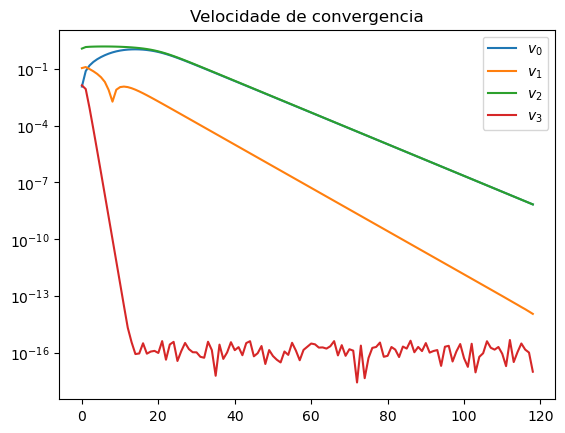

In [25]:
def base_angles_prec(B1,B2):
    return [proj_angle_prec(B1[i], B2[i]) for i in range(len(B1))]
np.random.seed(999)
A, _, a_vec = rand_diag(5)
Qs,_ = itera_qr(A)
tetha = []
for Q in Qs:
    QT = np.array(Q).T
    tetha_ = base_angles_prec(a_vec, QT)
    tetha.append(tetha_)
v = []
for i in range(len(tetha)):
    a = np.insert(tetha[i], len(tetha[i]), 0)
    dif = np.insert(tetha[i], 0, 0)
    speed = (np.abs(a - dif))[1:-1]
    v.append(speed)
plt.semilogy(v)
plt.title('Velocidade de convergencia')
plt.legend(['$v_{}$'.format(i) for i in range(4)], loc=0)